### Importamos Librerías

In [1]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px
from scipy import stats

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix, get_artifact_filename

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump

import warnings
warnings.filterwarnings("ignore")

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definimos rutas

In [23]:
#Subimos dos niveles para quedar en la carpeta que contiene input y lab2-mcd-austral
BASE_DIR = './'

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

# Problema I: Clasificación

Para clasificar decidimos utilizar el dataset de Titanic para predecir si una persona sobrevive o no.

Diccionario de datos

- Survived: Es la variable target, indica si la persona sobrevió o no. (0 = No, 1 = Si)
- Pclass: En que clase viajaba la persona  (1 = 1st, 2 = 2nd, 3 = 3rd)
- Age: Edad en años.
- Sex: Sexo (male, female)
- SibSp: Cantidad de hermanos o cónyuges a bordo del Titanic.
- Parch: Cantidad de padres o hijos a bordo del Titanic.
- Ticket: Número de ticket.
- Fare: Tarifa del pasajero.
- Cabin: Número de cabina
- Embarked: Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)

Leemos el dataset

In [3]:
df = pd.read_csv('./csv/titanic_train.csv')

### Análisis exploratorio de datos

Filas y Columnas

In [4]:
df.shape

(891, 12)

Datos

In [5]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Tipos de variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cantidad de nulos

In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cantidad de nulos expresados en porcentajes

In [8]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

Medidas de tendencia central y de dispersión

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Matriz de correlación

<Axes: >

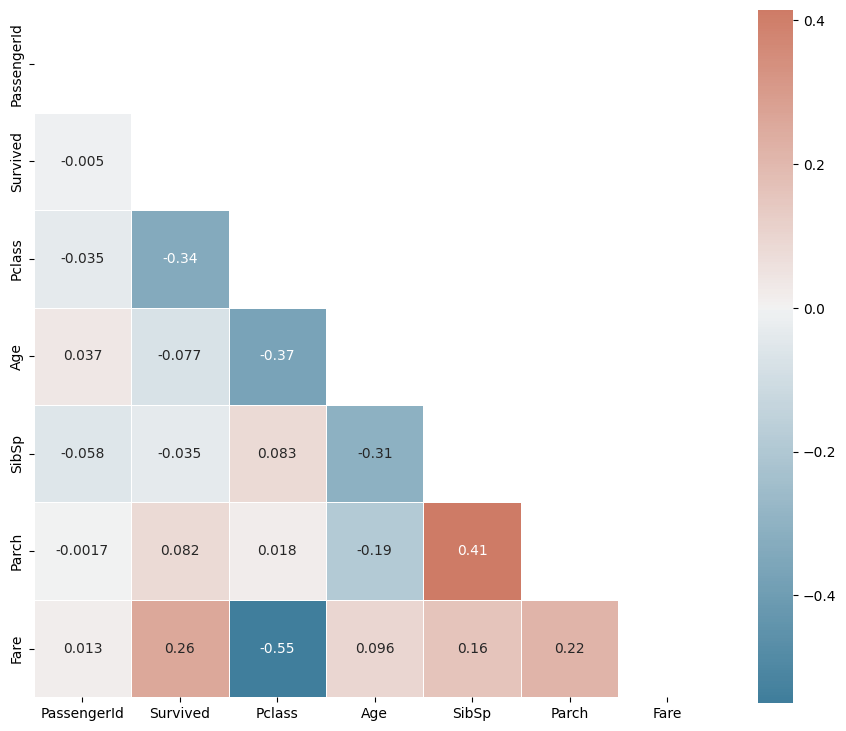

In [10]:
# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Eliminamos variables que no nos interesan.
#df_copy.drop(['index','education.num','education','workclass','marital.status','occupation','relationship','race','sex','native.country','income'], axis=1, inplace=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df[numeric_cols].corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df[numeric_cols].corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

Vemos que no hay correlación fuerte entre las variables.

Distribución de la variable target _"Survived"_

C:\Users\fcarreno\AppData\Local\Temp\ipykernel_18344\2659043324.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_percentages.index, y=income_percentages.values, palette='viridis')


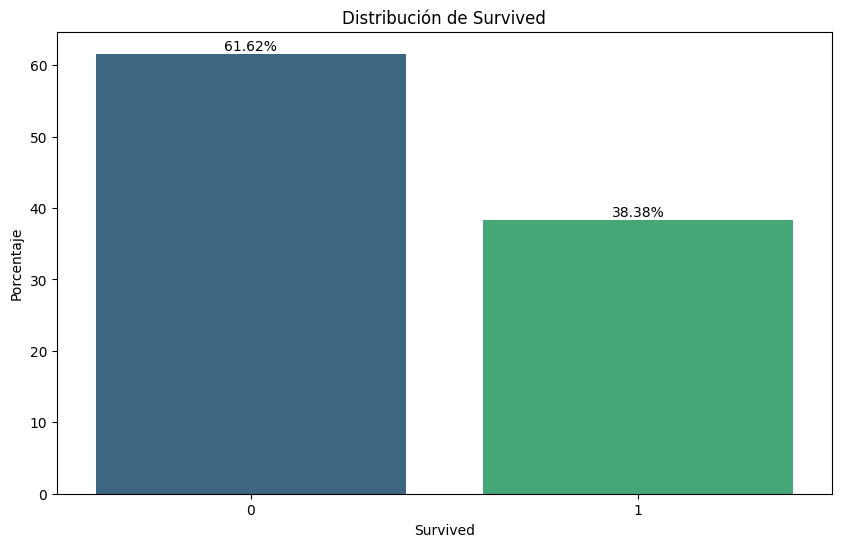

In [11]:
# Calcular los porcentajes
income_counts = df['Survived'].value_counts()
income_percentages = income_counts / income_counts.sum() * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=income_percentages.index, y=income_percentages.values, palette='viridis')

# Añadir los porcentajes en la parte superior de las barras
for index, value in enumerate(income_percentages.values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

# Personalizar el gráfico
plt.title('Distribución de Survived')
plt.xlabel('Survived')
plt.ylabel('Porcentaje')

plt.show()

Las clases están desbalanceadas. La mayoría de las personas no sobrevivieron al hundimiento del Titanic.

In [12]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Preprocesamiento y Feature Engineering

Eliminamos variable _Cabin_ por su alto procentaje de NAs 

In [13]:
df = df.drop(columns = ["Cabin"]) # eliminar la columna Cabin porque tienen un bastante valores NA

Creamos variable _"titulo"_

In [14]:
# Dado que el 20% de Age está null, necesito deducir las edades a partir del title.
df['titulo']=df['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
df['titulo'].value_counts()

titulo
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [15]:
df[df.Age.isnull()].groupby("titulo").size() # agrupo por título los datos null y cuento la cantidad de cada categoría

titulo
Dr          1
Master      4
Miss       36
Mr        119
Mrs        17
dtype: int64

Se completarán los valores de la _edad_ en base a la media de la edad por el titulo

In [16]:
# Se completarán los valores de la edad en base a la media de la edad por el titulo.
# tituloEdad tendrá la columna titulo+edad, que es la media de cada título.
tituloEdad = df[df.Age.isnull() == False].groupby("titulo").agg({"Age": "mean"}).reset_index()

In [17]:
#hacer un leftjoin entre data y tituloEdad sobre la columna título.
df = pd.merge(df, tituloEdad, how="left", on="titulo")
#reemplazo el nombre de la columna Age_x por Age.
df = df.rename (columns = {"Age_x" : "Age"}) #El "_x" se usa para distinguir la columna de la base de la izq.

In [18]:
#para las filas donde la edad es null y el título no es Mr, que tomen la media calculada anteriormente (Age_y) como Age,
#de lo contrario, que tome el dato como viene.
df["Age"] = np.where((df.Age.isnull()) & (df.titulo != "Mr"), df.Age_y, df.Age)
df = df.drop(columns = ["Age_y"])

Para los Mr, se calculará la _edad_ como la mediana de edad por Clase y Puerto de embarque

In [19]:
medianAge = df[df.Age.isnull() == False].groupby(["Pclass", "Embarked"]).agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = ["Pclass", "Embarked"])
df["Age"] = np.where(df.Age.isnull(), df.medianAge, df.Age)
df = df.drop(columns = ["medianAge"])

Imputamos NAs de _Embarked_ por la moda

In [20]:
#Reemplazo los nulls en Embarked por la moda de esta columna
df["Embarked"] = np.where(df.Embarked.isnull(), df.Embarked.mode().values[0], df.Embarked)

En base a la edad creamos una variable que será el Ratio entre la edad y la mediana de edad abierta por título

In [21]:
medianAge = df.groupby("titulo").agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = "titulo")
df["ageRatioTitle"] = df.Age / df.medianAge
df.drop(columns=["medianAge"], inplace = True)

Comenzamos a trabajar sobre la imputación de variables categóricas. Comenzaremos con la variable titulo. Para esta variable trabajaremos con el método WoE (Weigth of Evidence)

El concepto de weight of evidence surge con la generación de modelos de scoring de crédito para poder entender el poder predictivo de las variables independientes en relación con la variable dependiente. Como fue introducida en el mundo del riesgo, generalmente podemos encontrar la métrica como la separación de los buenos y los malos clientes. Los malos clientes se refieren a aquellos que llegaron a tener un default crediticio. No obstante lo podemos generalizar a la relación existente entre un evento y un no evento.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>W</mi>
  <mi>O</mi>
  <mi>E</mi>
  <mo>=</mo>
  <mi>ln</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mfrac>
    <mrow>
      <mi mathvariant="normal">%</mi>
      <mi>n</mi>
      <mi>o</mi>
      <mi>n</mi>
      <mi>E</mi>
      <mi>v</mi>
      <mi>e</mi>
      <mi>n</mi>
      <mi>t</mi>
      <mi>s</mi>
    </mrow>
    <mrow>
      <mi mathvariant="normal">%</mi>
      <mi>e</mi>
      <mi>v</mi>
      <mi>e</mi>
      <mi>n</mi>
      <mi>t</mi>
      <mi>s</mi>
    </mrow>
  </mfrac>
  <mo stretchy="false">)</mo>
</math>

Aplicamos WoE a _SibSp_

In [22]:
# Transformar la columna SibSp con la variable target Survived y reemplazo la columna SibSp por el cálculo woe_sibSp
WOE_encoder = WOEEncoder()
sibSp = WOE_encoder.fit_transform(df["SibSp"].astype(str), df.Survived)
df = df.join(sibSp.rename(columns = {"SibSp":"woe_sibSp"}))

Creamos variable _withFamily_

In [23]:
#creamos la variable withfamily considerando SibSp y Parch.
df["withFamily"] = np.where((df.SibSp+df.Parch) >= 0, 1, 0)

Eliminamos columna _Sibsp_

In [24]:
#eliminamos la columna SibSp
df.drop(columns=["SibSp"], inplace=True)

Aplicamos WoE a _Parch_

In [25]:
#hacer el mismo proceso con Parch
WOE_encoder = WOEEncoder()
parch = WOE_encoder.fit_transform(df["Parch"].astype(str), df.Survived)
df = df.join(parch.rename(columns = {"Parch":"woe_parch"}))
df.drop(columns=["Parch"], inplace=True)

Aplicamos WoE a _Titulo_

In [26]:
#lo mismo con la variable Título
WOE_encoder = WOEEncoder()
titulo = WOE_encoder.fit_transform(df["titulo"].astype(str), df.Survived)
df = df.join(titulo.rename(columns = {"titulo":"woe_title"}))
df.drop(columns=["titulo"], inplace=True)

Creamos varaible _ageRatioClass_

In [27]:
medianAge = df.groupby("Pclass").agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = "Pclass")
df["ageRatioClass"] = df.Age / df.medianAge
df.drop(columns=["medianAge"], inplace = True)

Creamos variable _fareRatioClass_

In [28]:
df = pd.merge(df,
         df.groupby("Pclass").agg({"Fare": "median"}).reset_index().rename(columns={"Fare": "medianFare"}),
         how = "inner", on="Pclass")
df["fareRatioClass"] = df.Fare / df.Age
df.drop(columns=["medianFare"], inplace=True)

Aplicamos OneHotEncoder a _Sex_

In [29]:
df.join(pd.get_dummies(df[["Sex"]]))
df.drop(columns=["Sex"], inplace=True)

Aplicamos OneHotEncoder a _Embarked_

In [30]:
df.join(pd.get_dummies(df[["Embarked"]]))
df.drop(columns=["Embarked"], inplace=True)

Aplicamos OneHotEncodera _Pclass_

In [31]:
df.join(pd.get_dummies(df[["Pclass"]].astype(str)))
df.drop(columns=["Pclass"], inplace=True)

Eliminamos columnas _Name_ y _Ticket_

In [32]:
df.drop(columns=["Name", "Ticket"], inplace=True)

Guardamos el dataset preprocesado

In [33]:
df.to_csv('./csv/titanicPreprocesada.csv', index=False, sep=';')

Levantamos el dataset preprocesado

In [34]:
df = pd.read_csv('./csv/titanicPreprocesada.csv', sep=';')

Normalizar variables numéricas

In [35]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
columns_not_scaler = ['PassengerId','Survived','withFamily']
numeric_features = [col for col in numeric_features if col not in columns_not_scaler]

In [36]:
# Estandarizar las columnas numéricas
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

### Train Test

In [37]:
SEED = 12345
TEST_SIZE = 0.2

In [38]:
X = df.drop(columns = ["Survived"])
y = df.Survived

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [39]:
# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [40]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 712 filas
X_test: 179 filas
y_train: 712 filas
y_test: 179 filas


### Modelos

A continuación vamos a hacer la optimización de hiperparámetros, entrenamiento y validación de los modelos utilizando el framework de optuna, que nos provee una aplicación web para ir monitoreando el progreso de la optimización. Se utilizará además 5 fold cross validation.

### Modelo I: _Support Vector Machine Classifier_

In [41]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK.

def cv_es_svc_objective(trial,kernel):

    svc_params = {  'C': trial.suggest_loguniform('C', 0.2, 10),
                    'kernel': kernel,
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                    'probability': True
                    } 
    if kernel == 'linear':
       svc_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
    if kernel == 'rbf':
        svc_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 10)
    elif kernel == 'poly':
        svc_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
        svc_params['gamma'] = "scale"
        svc_params['degree'] = trial.suggest_int('degree', 2, 5)
    elif kernel == 'sigmoid':
        svc_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 1e1)
        svc_params['degree'] = trial.suggest_int('degree', 2, 5)
    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        svc_model = SVC(**svc_params, random_state=42)
        
        # Entrenar el modelo
        svc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += svc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, svc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

C:\Users\fcarreno\AppData\Local\Temp\ipykernel_18344\551731212.py:92: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)


Iniciamos optuna para el modelo VSM Classifier con kernel RBF

In [ ]:
#Inicio el store de artefactos (archivos) de optuna

def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['rbf'])
    return cv_es_svc_objective(trial, kernel)
#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  
                            study_name="SupportVectorClassifier RBF",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 53

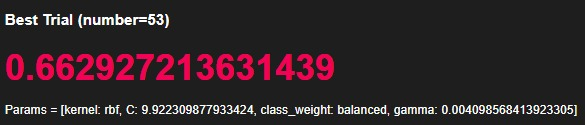

Iniciamos optuna para el modelo VSM Classifier con kernel sigmoide

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['sigmoid'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Sigmoid",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 1

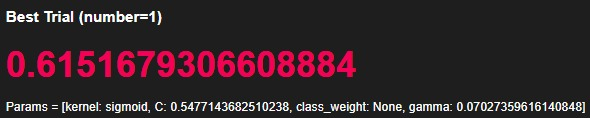

Iniciamos optuna para el modelo VSM Classifier con kernel lineal

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['linear'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Linear",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 3

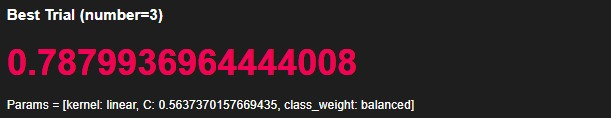

Iniciamos optuna para el modelo VSM Classifier con kernel polinómico

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['poly'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Poly",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 0

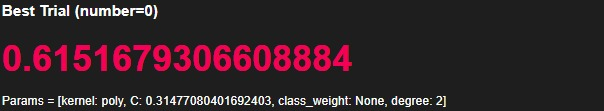

### Modelo II: _Random Forest Classifier_

In [61]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK

def cv_es_rfc_objective(trial):

    #Parametros
    rfc_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                        'max_depth': trial.suggest_int('max_depth', 3, 15),
                        #'max_depth': trial.suggest_int('max_depth', 3, 4)
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        rfc_model = RandomForestClassifier(**rfc_params, random_state=42)
        
        # Entrenar el modelo
        rfc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += rfc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, rfc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

Iniciamos optuna para el modelo RandomForestClassifier

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestClasiffier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_rfc_objective, n_trials=100)

El mejor conjunto de hiperarámetros se encontró en el trial 32

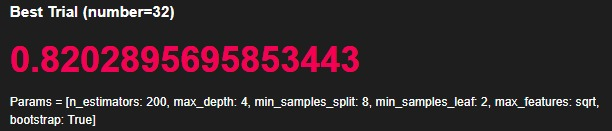

### Modelo III: _Gradient Boosting Classifier_

In [64]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK

def cv_es_gbc_objective(trial):

    #Parametros para LightGBM
    gbc_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 'auto']),
                        #'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        gbc_model = GradientBoostingClassifier(**gbc_params, random_state=42)
        
        # Entrenar el modelo
        gbc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += gbc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, gbc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

Iniciamos optuna para el modelo GradientBoostingClassifier

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="GradientBoostingClasiffier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbc_objective, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 37

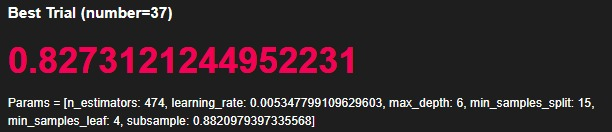

### Modelo IV: _Multilayer Perceptron Classifier_

In [70]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK

def cv_es_mlp_objective(trial):

    #Parametros
    mlp_params = {      
                        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
                            (50,), (100,), (50, 50), (100, 50), (100, 100)
                        ]),
                        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
                        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
                        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
                        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                        'max_iter': trial.suggest_int('max_iter', 100, 500),
                        'early_stopping': trial.suggest_categorical('early_stopping', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        mlp_model = MLPClassifier(**mlp_params, random_state=42)
        
        # Entrenar el modelo
        mlp_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += mlp_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, mlp_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

Iniciamos optuna para el modelo Multilayer Perceptron Classifier

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="MultilayerPerceptronClassifier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_mlp_objective, n_trials=100)

Los mejores hiperparámetros se dieron en el trial 75

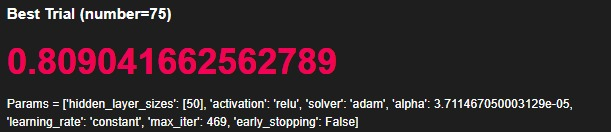

### Modelos en Optuna

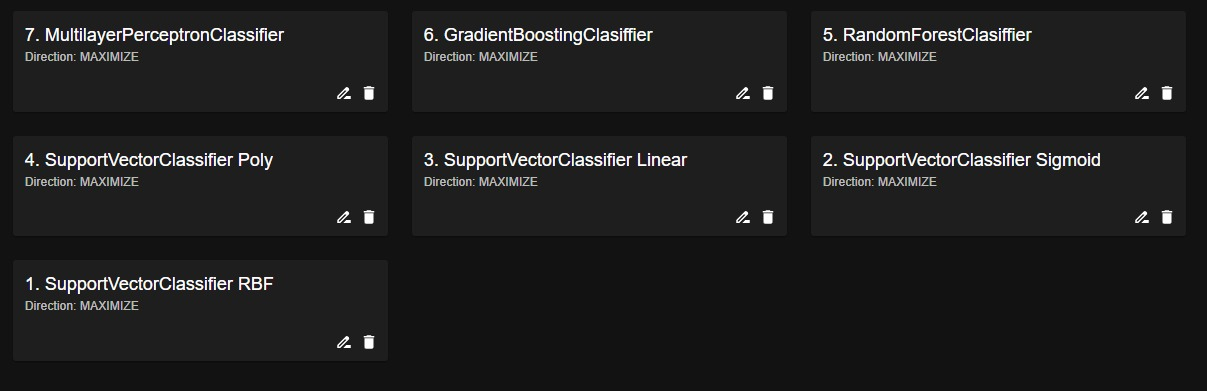

### Métricas y Gráficos

#### Gráfico I: Accuracy en Train y Test

<Axes: title={'center': 'Train y test'}, xlabel='study'>

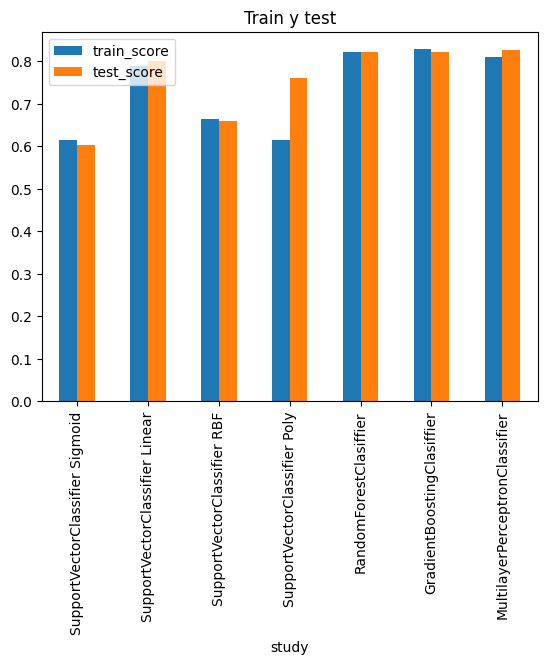

In [97]:
storage = 'sqlite:///prueba.sqlite3'
studies_names = ['SupportVectorClassifier Sigmoid', 
           'SupportVectorClassifier Linear', 
           'SupportVectorClassifier RBF',
           'SupportVectorClassifier Poly', 
           'RandomForestClasiffier', 
           'GradientBoostingClasiffier',
           'MultilayerPerceptronClassifier']

studies = [optuna.load_study(study_name=study_name, storage=storage) for study_name in studies_names]

df_result = pd.DataFrame()
df_result['study'] = [study.study_name for study in studies]
df_result['best_params'] = [study.best_params for study in studies]
df_result['train_score'] = [study.best_trial.value for study in studies]
df_result['test_score'] = [study.best_trial.user_attrs['test_score'] for study in studies]
df_result.set_index('study', inplace=True   )

df_result[['test_score','train_score']].sort_values('test_score',ascending=False,inplace=True,)

df_result.plot(kind='bar', title='Train y test')

#### Gráfico II: Curva ROC

In [106]:
# entrenar todos los modelo para hacer predicciones y construir curva ROC
m_svm_sigmoid = SVC(**df_result["best_params"]["SupportVectorClassifier Sigmoid"],probability=True,random_state=42)
m_svm_sigmoid.fit(X_train, y_train)

m_svm_linear = SVC(**df_result["best_params"]["SupportVectorClassifier Linear"],probability=True,random_state=42)
m_svm_linear.fit(X_train, y_train)

m_svm_rbf = SVC(**df_result["best_params"]["SupportVectorClassifier RBF"],probability=True,random_state=42)
m_svm_rbf.fit(X_train, y_train)

m_svm_poly = SVC(**df_result["best_params"]["SupportVectorClassifier Poly"],probability=True,random_state=42)
m_svm_poly.fit(X_train, y_train)

m_rf = RandomForestClassifier(**df_result["best_params"]["RandomForestClasiffier"],random_state=42)
m_rf.fit(X_train, y_train)

m_gb = GradientBoostingClassifier(**df_result["best_params"]["GradientBoostingClasiffier"],random_state=42)
m_gb.fit(X_train, y_train)

m_mlp = MLPClassifier(**df_result["best_params"]["MultilayerPerceptronClassifier"],random_state=42)
m_mlp.fit(X_train, y_train)


MLPClassifier(alpha=3.711467050003129e-05, hidden_layer_sizes=[50],
              max_iter=469, random_state=42)

In [140]:
# hacer las predicciones
preds = pd.DataFrame()
preds["m_svm_sigmoid"] = m_svm_sigmoid.predict_proba(X_test)[:,1]
preds["m_svm_linear"] = m_svm_linear.predict_proba(X_test)[:,1]
preds["m_svm_rbf"] = m_svm_rbf.predict_proba(X_test)[:,1]
preds["m_svm_poly"] = m_svm_poly.predict_proba(X_test)[:,1]
preds["m_rf"] = m_rf.predict_proba(X_test)[:,1]
preds["m_gb"] = m_gb.predict_proba(X_test)[:,1]
preds["m_mlp"] = m_mlp.predict_proba(X_test)[:,1]

In [141]:
# Calcular la curva ROC y el AUC
fpr_svm_sigmoid, tprsvm_sigmoid, _ = roc_curve(y_test, preds["m_svm_sigmoid"])
roc_auc_svm_sigmoid = auc(fpr_svm_sigmoid, tprsvm_sigmoid)

fpr_svm_linear, tpr_svm_linear, _ = roc_curve(y_test, preds["m_svm_linear"])
roc_auc_svm_linear = auc(fpr_svm_linear, tpr_svm_linear)

fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, preds["m_svm_rbf"])
roc_auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

fpr_svm_poly, tpr_svm_poly, _ = roc_curve(y_test, preds["m_svm_poly"])
roc_auc_svm_poly = auc(fpr_svm_poly, tpr_svm_poly)

fpr_rf, tpr_rf, _ = roc_curve(y_test, preds["m_rf"])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, preds["m_gb"])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, preds["m_mlp"])
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

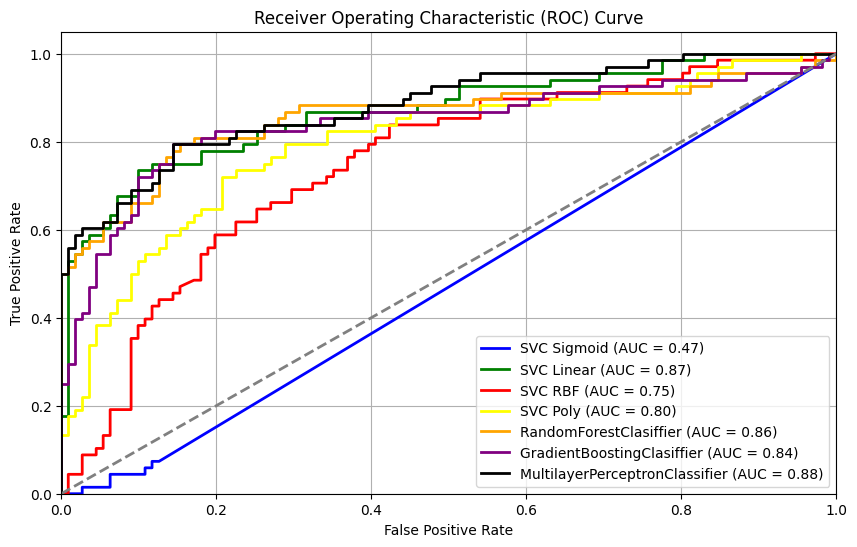

In [142]:
plt.figure(figsize=(10, 6))


plt.plot(fpr_svm_sigmoid, tprsvm_sigmoid, color='blue', lw=2, label=f'SVC Sigmoid (AUC = {roc_auc_svm_sigmoid:.2f})')
plt.plot(fpr_svm_linear, tpr_svm_linear, color='green', lw=2, label=f'SVC Linear (AUC = {roc_auc_svm_linear:.2f})')
plt.plot(fpr_svm_rbf, tpr_svm_rbf, color='red', lw=2, label=f'SVC RBF (AUC = {roc_auc_svm_rbf:.2f})')
plt.plot(fpr_svm_poly, tpr_svm_poly, color='yellow', lw=2, label=f'SVC Poly (AUC = {roc_auc_svm_poly:.2f})')
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label=f'RandomForestClasiffier (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, color='purple', lw=2, label=f'GradientBoostingClasiffier (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='black', lw=2, label=f'MultilayerPerceptronClassifier (AUC = {roc_auc_mlp:.2f})')

# Graficar la línea de referencia
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Configurar detalles del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Mostrar el gráfico
plt.show()

#### Gráfico III: Matríz de confusión

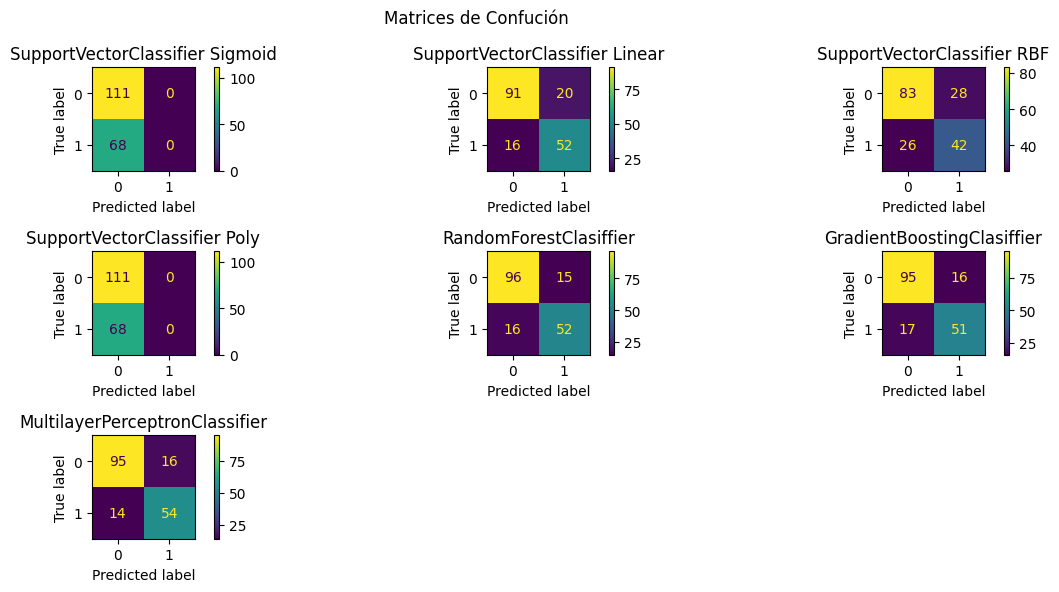

In [147]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

cm_svm_sigmoid= metrics.confusion_matrix(y_test, m_svm_sigmoid.predict(X_test))
cm_svm_linear= metrics.confusion_matrix(y_test, m_svm_linear.predict(X_test))
cm_svm_rbf= metrics.confusion_matrix(y_test, m_svm_rbf.predict(X_test))
cm_svm_poly= metrics.confusion_matrix(y_test, m_svm_poly.predict(X_test))
cm_rf= metrics.confusion_matrix(y_test, m_rf.predict(X_test))
cm_gb= metrics.confusion_matrix(y_test, m_gb.predict(X_test))
cm_mlp= metrics.confusion_matrix(y_test, m_mlp.predict(X_test))

metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_sigmoid, display_labels = [0, 1]).plot(ax=ax[0,0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_linear, display_labels = [0, 1]).plot(ax=ax[0,1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_rbf, display_labels = [0, 1]).plot(ax=ax[0,2])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_poly, display_labels = [0, 1]).plot(ax=ax[1,0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = [0, 1]).plot(ax=ax[1,1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_gb, display_labels = [0, 1]).plot(ax=ax[1,2])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_mlp, display_labels = [0, 1]).plot(ax=ax[2,0])

ax[0,0].set_title('SupportVectorClassifier Sigmoid')
ax[0,1].set_title('SupportVectorClassifier Linear')
ax[0,2].set_title('SupportVectorClassifier RBF')
ax[1,0].set_title('SupportVectorClassifier Poly')
ax[1,1].set_title('RandomForestClasiffier')
ax[1,2].set_title('GradientBoostingClasiffier')
ax[2,0].set_title('MultilayerPerceptronClassifier')


fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

plt.suptitle("Matrices de Confución")
plt.tight_layout()

plt.show()

### Métricas

##### Métricas del SVM Sigmoid

In [152]:
print(classification_report(y_test,m_svm_sigmoid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       111
           1       0.00      0.00      0.00        68

    accuracy                           0.62       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.62      0.47       179



##### Métricas del SVM Lineal

In [153]:
print(classification_report(y_test,m_svm_linear.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       111
           1       0.72      0.76      0.74        68

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



##### Métricas del SVM RBF

In [154]:
print(classification_report(y_test,m_svm_rbf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       111
           1       0.60      0.62      0.61        68

    accuracy                           0.70       179
   macro avg       0.68      0.68      0.68       179
weighted avg       0.70      0.70      0.70       179



##### Métricas del SVM Poly

In [155]:
print(classification_report(y_test,m_svm_poly.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       111
           1       0.00      0.00      0.00        68

    accuracy                           0.62       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.62      0.47       179



##### Métricas del Random Forest

In [156]:
print(classification_report(y_test,m_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       111
           1       0.78      0.76      0.77        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



##### Métricas del Gradient Boosting 

In [157]:
print(classification_report(y_test,m_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       111
           1       0.76      0.75      0.76        68

    accuracy                           0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



##### Métricas del MLP

In [158]:
print(classification_report(y_test,m_mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       111
           1       0.77      0.79      0.78        68

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



# Problema II: Regresión

Para regresión decidimos utilizar el dataset "car-prices" donde lo que se busca es predecir el precio de un vehículo.

Diccionario de datos
- Brand: marca del vehículo.
- Body: Tipo de vehículo.
- Mileage: kilometrage.
- EngineV: Tipo de motor.
- Registration: si el vehículo está registrado o no.
- Year: año de lanzamiento.
- Model: modelo del vehículo.
- Price: precio del vehículo (variable target)

Leemos el dataset

In [2]:
df = pd.read_csv('./csv/car-prices.csv')

### Análisis exploratorio de datos

Filas y columnas

In [39]:
df.shape

(4345, 23)

Datos

In [5]:
df.head(1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320


Tipos de variables

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


Cantidad de NAs

In [59]:
df.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

Porcentaje de NAs

In [ ]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

Medidas de tendencia central y de dispersión

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,4173.0,19418.746935,25584.242620,600.0,6999.0,11500.0,21700.0,300000.00
Mileage,4345.0,161.237284,105.705797,0.0,86.0,155.0,230.0,980.00
EngineV,4195.0,2.790734,5.066437,0.6,1.8,2.2,3.0,99.99
Year,4345.0,2006.550058,6.719097,1969.0,2003.0,2008.0,2012.0,2016.00


Matriz de correlación

<Axes: >

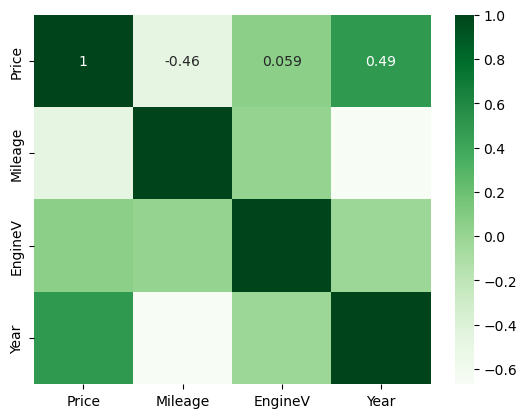

In [62]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
matrix = df[numeric_cols].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

Price es nuestro target, ¿cómo se distribuye?

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

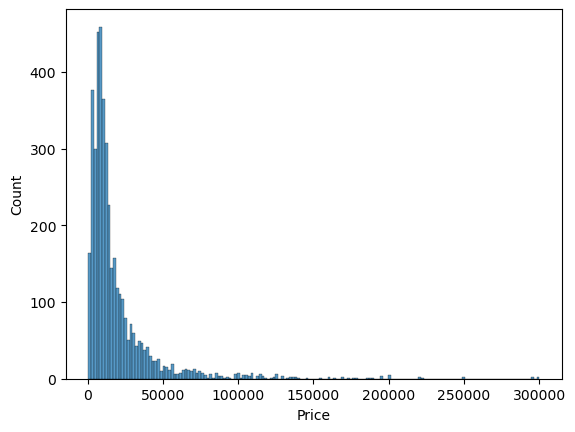

In [63]:
sns.histplot(x= 'Price', data=df)

Boxplot: Variables categóricas vs Price

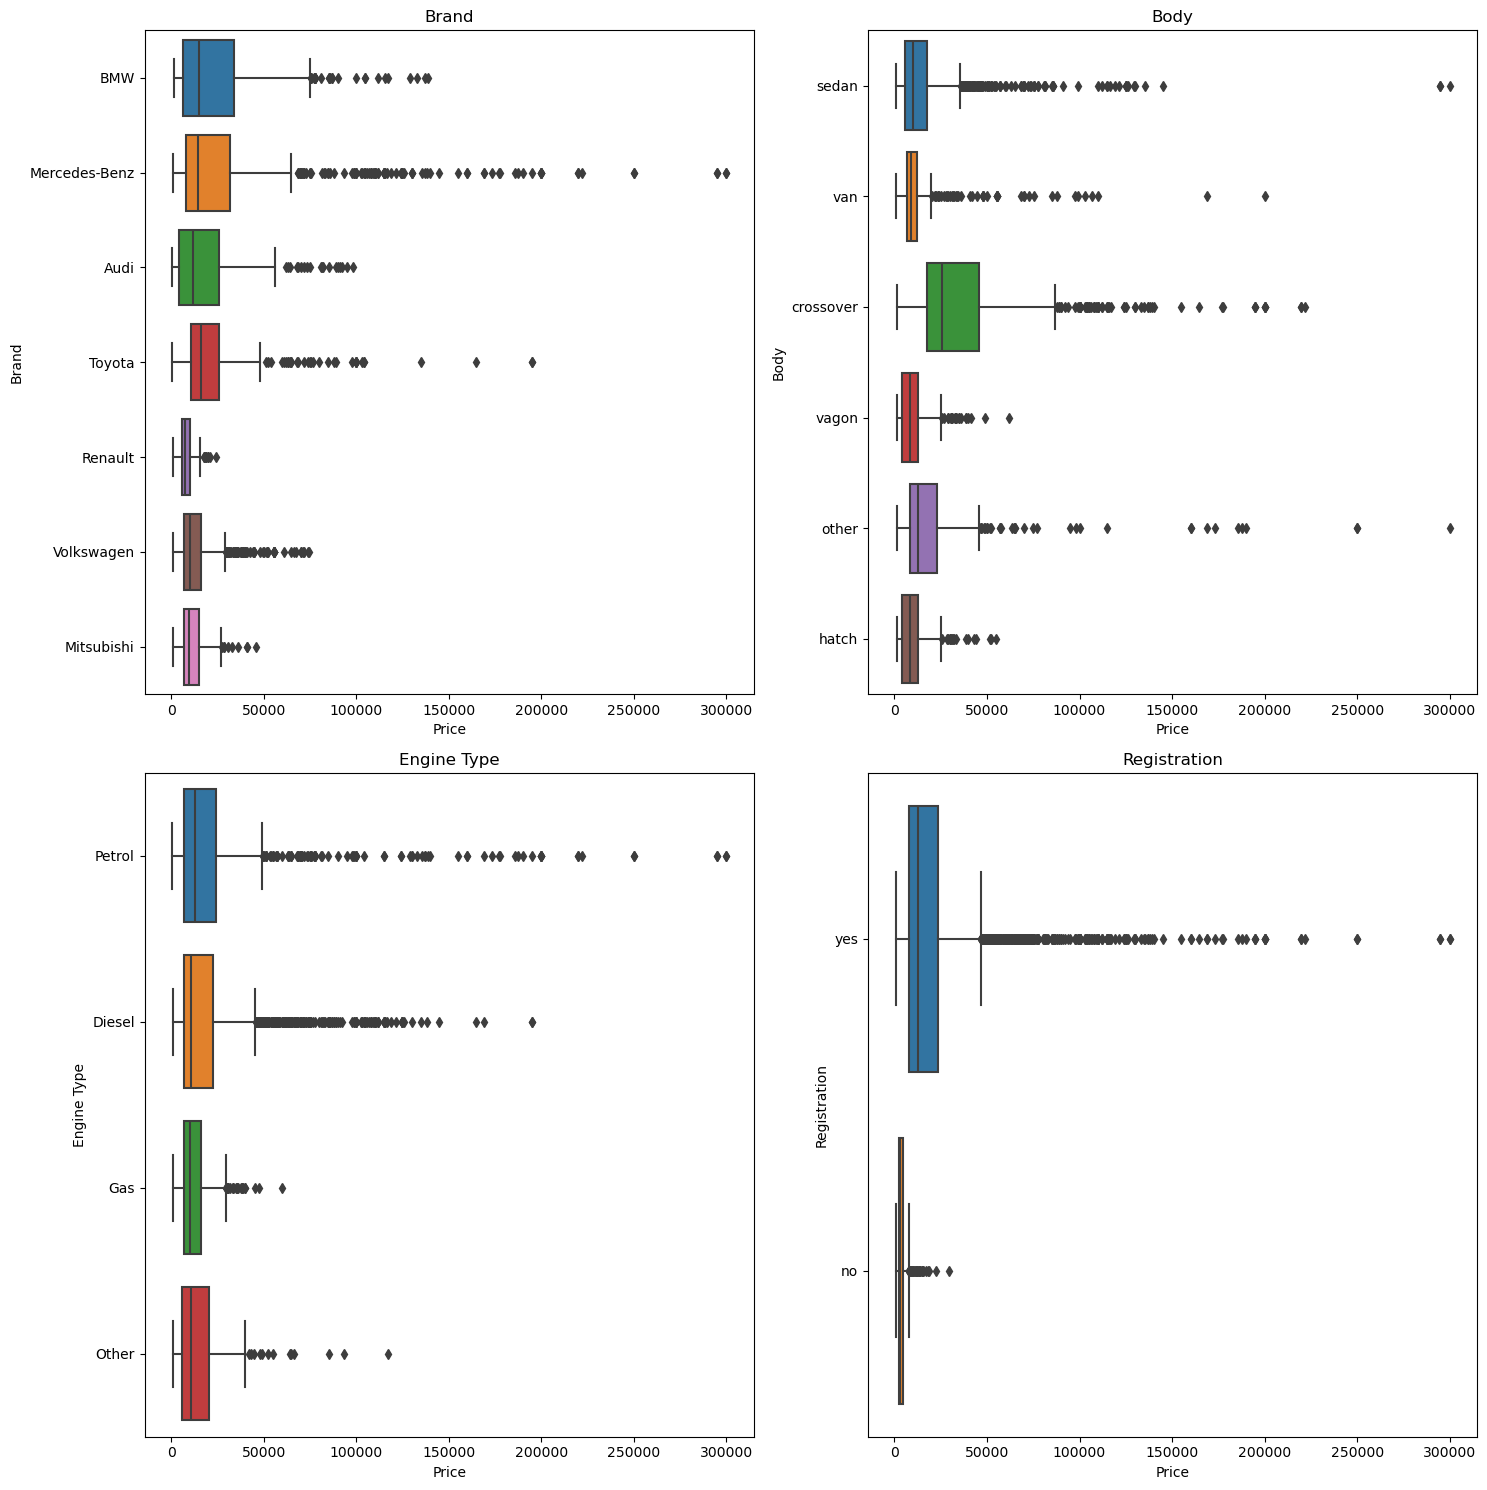

In [71]:
categorical_features = ['Brand', 'Body', 'Engine Type', 'Registration']
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.boxplot(data=df,
                x="Price", y=col,
                ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Variables continuas vs Price

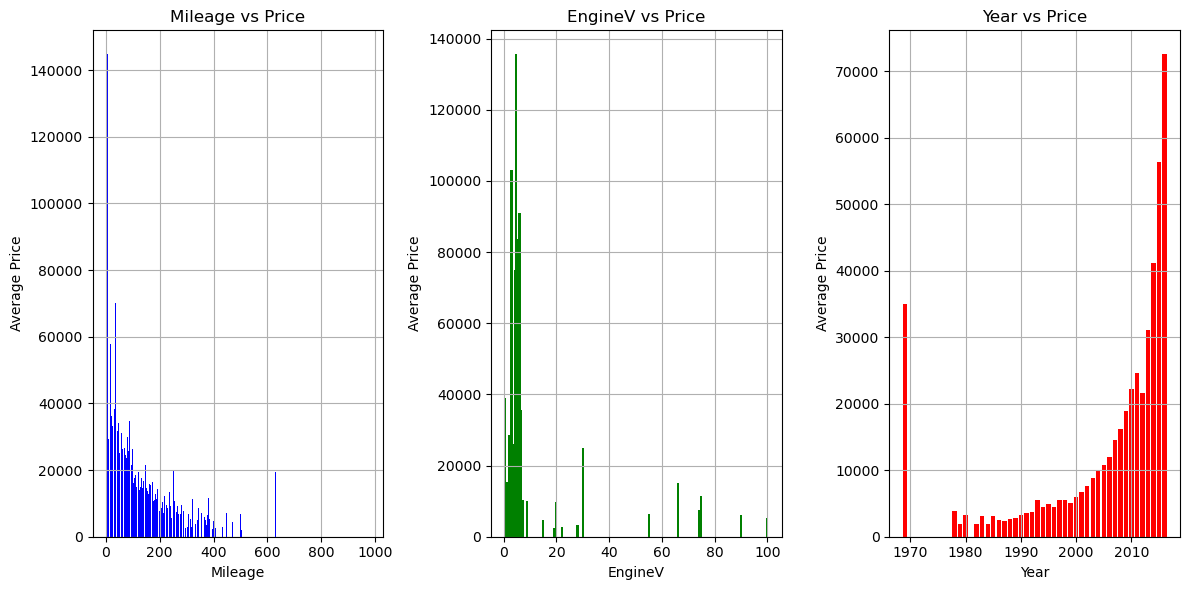

In [72]:
# Calcular el promedio de Price para cada valor único de Mileage, EngineV y Year
avg_price_mileage = df.groupby('Mileage')['Price'].mean()
avg_price_enginev = df.groupby('EngineV')['Price'].mean()
avg_price_year = df.groupby('Year')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))

# Gráfico de barras para Mileage vs Price
plt.subplot(1, 3, 1)
plt.bar(avg_price_mileage.index, avg_price_mileage.values, color='blue')
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para EngineV vs Price
plt.subplot(1, 3, 2)
plt.bar(avg_price_enginev.index, avg_price_enginev.values, color='green')
plt.title('EngineV vs Price')
plt.xlabel('EngineV')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para Year vs Price
plt.subplot(1, 3, 3)
plt.bar(avg_price_year.index, avg_price_year.values, color='red')
plt.title('Year vs Price')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)

# Ajustar automáticamente la distribución de los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Rango de _"Years"_

In [29]:
print(f"Desde {df.Year.min()} hasta {df.Year.max()}")

1969

### Preprocesamiento y Feature Engineering

Imputamos Price

In [3]:
# Imputación de valores faltantes con la mediana
median_price = df['Price'].median()
df['Price'].fillna(median_price, inplace=True)

Imputamos medina_enginev

In [4]:
# Imputación de valores faltantes con la mediana
median_enginev = df['EngineV'].median()
df['EngineV'].fillna(median_enginev, inplace=True)


Vamos a descartar la variable Model por simplicidad

In [5]:
df.drop(['Model'], inplace=True, axis=1)

Normalizar

In [6]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Price']]
columns_to_keep = ['Mileage', 'EngineV']
numeric_features_to_scale = [col for col in numeric_features if col in columns_to_keep]

In [7]:
# Estandarizar las columnas numéricas
scaler = StandardScaler()
df[numeric_features_to_scale] = scaler.fit_transform(df[numeric_features_to_scale])

Categoricas: OneHotEncoder

In [8]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [9]:
df = pd.get_dummies(df, columns=categorical_features)

### Train y Test

In [10]:
SEED = 12345
TEST_SIZE = 0.2

In [11]:
X = df.drop(columns=['Price'])  # Variables predictoras
y = df['Price']  # Variable objetivo

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [12]:
# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [13]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 3476 filas
X_test: 869 filas
y_train: 3476 filas
y_test: 869 filas


### Modelos

A continuación vamos a hacer la optimización de hiperparámetros, entrenamiento y validación de los modelos utilizando el framework de optuna, que nos provee una aplicación web para ir monitoreando el progreso de la optimización. Se utilizará además 5 fold cross validation.

### Modelo I: _Support Vector Regressor_

In [31]:
def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]  # número de predictores
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

def cv_es_svr_objective(trial,kernel):
     
    svr_params = {  'C':  trial.suggest_float('C',0.2,10, log=True),
                    'kernel': kernel                   
                    } 
    if kernel == 'linear':
       svr_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
    if kernel == 'rbf':
        svr_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 10)
    elif kernel == 'poly':
        svr_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
        svr_params['gamma'] = "scale"
        svr_params['degree'] = trial.suggest_int('degree', 2, 5)
    elif kernel == 'sigmoid':
        svr_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 1e1)
        svr_params['degree'] = trial.suggest_int('degree', 2, 5)

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo SVR con los parámetros sugeridos
        svr_model = SVR(**svr_params)
        
        # Entrenar el modelo
        svr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += svr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += adjusted_r2_score(y_oof, svr_model.predict(X_oof),X_test) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = adjusted_r2_score(y_test, predictions_ensemble,X_test)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

Iniciamos optuna para SVR con kernel RBF

In [32]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Inicio el store de artefactos (archivos) de optuna
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['rbf'])
    return cv_es_svr_objective(trial, kernel)
#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor RBF",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

[I 2024-07-16 17:38:36,902] A new study created in RDB with name: SupportVectorRegressor RBF
[I 2024-07-16 17:38:42,281] Trial 0 finished with value: -0.11555253869288552 and parameters: {'kernel': 'rbf', 'C': 1.9097513999861724, 'gamma': 0.01896890830490951}. Best is trial 0 with value: -0.11555253869288552.
[I 2024-07-16 17:38:47,643] Trial 1 finished with value: -0.1276281145459073 and parameters: {'kernel': 'rbf', 'C': 5.168792619712964, 'gamma': 4.344192606725146e-05}. Best is trial 0 with value: -0.11555253869288552.
[I 2024-07-16 17:38:52,857] Trial 2 finished with value: -0.099045834971575 and parameters: {'kernel': 'rbf', 'C': 4.378427732847322, 'gamma': 0.004755594091118563}. Best is trial 2 with value: -0.099045834971575.
[I 2024-07-16 17:39:00,762] Trial 3 finished with value: -0.12791864234495148 and parameters: {'kernel': 'rbf', 'C': 3.3489649981648926, 'gamma': 5.499610923150508}. Best is trial 2 with value: -0.099045834971575.
[I 2024-07-16 17:39:07,576] Trial 4 finishe

Iniciamos optuna para SVR con kernel sigmoide

In [34]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['sigmoid'])
    return cv_es_svr_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Sigmoid",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

[I 2024-07-16 17:49:11,660] Using an existing study with name 'SupportVectorRegressor Sigmoid' instead of creating a new one.
[I 2024-07-16 17:49:14,286] Trial 14 finished with value: -0.12810535127230546 and parameters: {'kernel': 'sigmoid', 'C': 2.663351477688986, 'gamma': 0.0824703156826987, 'degree': 2}. Best is trial 0 with value: -0.12810535127230546.
[I 2024-07-16 17:49:16,647] Trial 15 finished with value: -0.12810535127230546 and parameters: {'kernel': 'sigmoid', 'C': 0.8822210069335295, 'gamma': 0.0007295349162629298, 'degree': 4}. Best is trial 0 with value: -0.12810535127230546.
[I 2024-07-16 17:49:19,480] Trial 16 finished with value: -0.12810535127230546 and parameters: {'kernel': 'sigmoid', 'C': 1.6424191208796695, 'gamma': 6.877136493914762, 'degree': 2}. Best is trial 0 with value: -0.12810535127230546.
[I 2024-07-16 17:49:21,845] Trial 17 finished with value: -0.12810535127230546 and parameters: {'kernel': 'sigmoid', 'C': 5.816045161332395, 'gamma': 0.0035351636486075

Iniciamos optuna para SVR con kernel lineal

In [35]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['linear'])
    return cv_es_svr_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Linear",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

[I 2024-07-16 17:53:58,532] A new study created in RDB with name: SupportVectorRegressor Linear
[I 2024-07-16 17:54:01,456] Trial 0 finished with value: 0.11491191770727163 and parameters: {'kernel': 'linear', 'C': 4.884755237239937}. Best is trial 0 with value: 0.11491191770727163.
[I 2024-07-16 17:54:03,933] Trial 1 finished with value: 0.08396562883405945 and parameters: {'kernel': 'linear', 'C': 1.9944360791069393}. Best is trial 0 with value: 0.11491191770727163.
[I 2024-07-16 17:54:06,522] Trial 2 finished with value: 0.03200626497161767 and parameters: {'kernel': 'linear', 'C': 0.3139807393066441}. Best is trial 0 with value: 0.11491191770727163.
[I 2024-07-16 17:54:08,978] Trial 3 finished with value: 0.09815629799780391 and parameters: {'kernel': 'linear', 'C': 3.0750794668127006}. Best is trial 0 with value: 0.11491191770727163.
[I 2024-07-16 17:54:11,587] Trial 4 finished with value: 0.13112387337066372 and parameters: {'kernel': 'linear', 'C': 7.417339916531007}. Best is tr

Iniciamos optuna para SVR con kernel polinómico

In [36]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['poly'])
    return cv_es_svr_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Poly",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

[I 2024-07-16 18:00:00,849] A new study created in RDB with name: SupportVectorRegressor Poly
[I 2024-07-16 18:00:04,001] Trial 0 finished with value: -0.1281043431634191 and parameters: {'kernel': 'poly', 'C': 0.24804303096606087, 'degree': 2}. Best is trial 0 with value: -0.1281043431634191.
[I 2024-07-16 18:00:07,224] Trial 1 finished with value: -0.128055946530157 and parameters: {'kernel': 'poly', 'C': 9.57194002365658, 'degree': 4}. Best is trial 1 with value: -0.128055946530157.
[I 2024-07-16 18:00:10,667] Trial 2 finished with value: -0.12809823034343082 and parameters: {'kernel': 'poly', 'C': 3.740472324592473, 'degree': 2}. Best is trial 1 with value: -0.128055946530157.
[I 2024-07-16 18:00:13,868] Trial 3 finished with value: -0.12809884515797498 and parameters: {'kernel': 'poly', 'C': 0.6865744890804443, 'degree': 4}. Best is trial 1 with value: -0.128055946530157.
[I 2024-07-16 18:00:16,560] Trial 4 finished with value: -0.1281024583533727 and parameters: {'kernel': 'poly'

### Modelo II: _Random Forest Regressor_

In [37]:
def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]  # número de predictores
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

def cv_es_rfr_objective(trial):

    rfr_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                        'max_depth': trial.suggest_int('max_depth', 3, 15),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
                        } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo rfr con los parámetros sugeridos
        rfr_model = RandomForestRegressor(**rfr_params)
        
        # Entrenar el modelo
        rfr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += rfr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += adjusted_r2_score(y_oof, rfr_model.predict(X_oof), X_test) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = adjusted_r2_score(y_test, predictions_ensemble,X_test)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

Iniciamos optuna para RandomForestRegressor

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_rfr_objective, n_trials=100)

### Modelo III: _Gradient Boosting_

In [39]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK.

def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]  # número de predictores
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

def cv_es_gbr_objective(trial):

    
    gbr_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
                 } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo gbr con los parámetros sugeridos
        gbr_model = GradientBoostingRegressor(**gbr_params)
        
        # Entrenar el modelo
        gbr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += gbr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += adjusted_r2_score(y_oof, gbr_model.predict(X_oof), X_test) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = adjusted_r2_score(y_test, predictions_ensemble, X_test)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

Iniciamos optuna para GradientBoostingRegressor

In [40]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="GradientBoostingRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbr_objective, n_trials=100)

[I 2024-07-16 18:27:55,777] A new study created in RDB with name: GradientBoostingRegressor
[I 2024-07-16 18:28:09,643] Trial 0 finished with value: 0.5045230119927382 and parameters: {'n_estimators': 460, 'learning_rate': 0.14434635598700998, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.9204116385282668}. Best is trial 0 with value: 0.5045230119927382.
[I 2024-07-16 18:28:28,238] Trial 1 finished with value: 0.4889174300399989 and parameters: {'n_estimators': 643, 'learning_rate': 0.08713067945894797, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2, 'subsample': 0.6016575538266905}. Best is trial 0 with value: 0.5045230119927382.
[I 2024-07-16 18:28:42,940] Trial 2 finished with value: 0.46775190334479794 and parameters: {'n_estimators': 594, 'learning_rate': 0.24267747201640216, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 5, 'subsample': 0.6500041505766228}. Best is trial 0 with value: 0.5045230119927382.
[I 2024-07-16

### Modelo IV: Multilayer Perceptron Regressor

In [42]:
#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK

def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]  # número de predictores
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

def cv_es_mlpr_objective(trial):


    mlpr_params = {      
                        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
                            (50,), (100,), (50, 50), (100, 50), (100, 100)
                        ]),
                        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
                        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
                        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
                        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                        'max_iter': trial.suggest_int('max_iter', 100, 500),
                        'early_stopping': trial.suggest_categorical('early_stopping', [True, False])
                        } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo mlpr con los parámetros sugeridos
        mlpr_model = MLPRegressor(**mlpr_params)
        
        # Entrenar el modelo
        mlpr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += mlpr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += adjusted_r2_score(y_oof, mlpr_model.predict(X_oof), X_test) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = adjusted_r2_score(y_test, predictions_ensemble, X_test)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

Iniciamos optuna para Multilayer Perceptron Regressor

In [43]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="MultilayerPerceptronRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_mlpr_objective, n_trials=100)

[I 2024-07-16 18:53:42,237] A new study created in RDB with name: MultilayerPerceptronRegressor
[I 2024-07-16 18:53:43,542] Trial 0 finished with value: -7.495110645224517e+111 and parameters: {'hidden_layer_sizes': [100, 100], 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.033805050675297654, 'learning_rate': 'constant', 'max_iter': 291, 'early_stopping': False}. Best is trial 0 with value: -7.495110645224517e+111.
[I 2024-07-16 18:53:52,079] Trial 1 finished with value: -0.6392296139678197 and parameters: {'hidden_layer_sizes': [50], 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0003991522326456447, 'learning_rate': 'adaptive', 'max_iter': 201, 'early_stopping': False}. Best is trial 1 with value: -0.6392296139678197.
[I 2024-07-16 18:53:58,720] Trial 2 finished with value: -0.034578783436340244 and parameters: {'hidden_layer_sizes': [100, 50], 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0009615295530220562, 'learning_rate': 'adaptive', 'max_iter': 106, 'early_s

#### Grafico I: R Cuadrado Ajustado - Train y Test

<Axes: title={'center': 'Train y test'}, xlabel='study'>

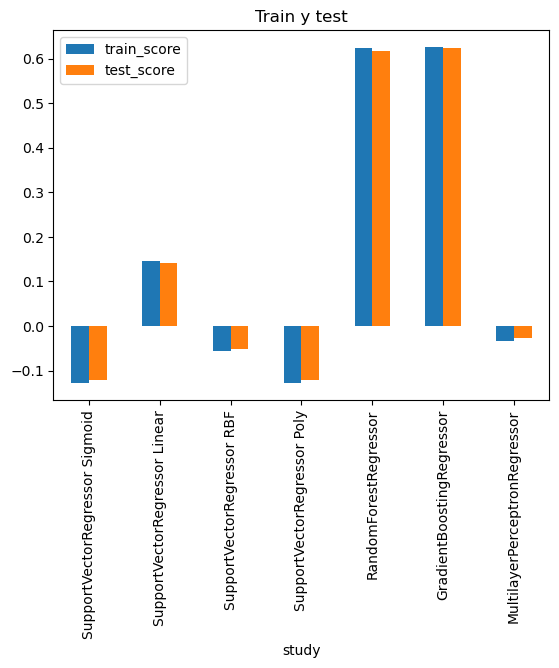

In [44]:
# Obtener el mejor resultado
storage = 'sqlite:///test2.sqlite3'
studies_names = ['SupportVectorRegressor Sigmoid', 
           'SupportVectorRegressor Linear', 
           'SupportVectorRegressor RBF',
           'SupportVectorRegressor Poly', 
           'RandomForestRegressor', 
           'GradientBoostingRegressor',
           'MultilayerPerceptronRegressor']

studies = [optuna.load_study(study_name=study_name, storage=storage) for study_name in studies_names]

df_result = pd.DataFrame()
df_result['study'] = [study.study_name for study in studies]
df_result['best_params'] = [study.best_params for study in studies]
df_result['train_score'] = [study.best_trial.value for study in studies]
df_result['test_score'] = [study.best_trial.user_attrs['test_score'] for study in studies]
df_result.set_index('study', inplace=True   )

df_result[['test_score','train_score']].sort_values('test_score',ascending=False,inplace=True,)

df_result.plot(kind='bar', title='Train y test')

Observamos como bajó el desempeño del modelo Multilayer Perceptrón en comparación al problema de clasificación. Los modelos RandomForest y GradientBoosting siguen siendo los mejores.

#### Gráfico II: Gráficos de dispersión de valores predichos vs reales

In [54]:
study_svr_sigmoid = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Sigmoid",
                            load_if_exists = True)


svr_sigmoid_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_svr_sigmoid,'test')))

[I 2024-07-16 19:38:14,890] Using an existing study with name 'SupportVectorRegressor Sigmoid' instead of creating a new one.


In [55]:
study_svr_linear = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Linear",
                            load_if_exists = True)


svr_linear_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_svr_linear,'test')))

[I 2024-07-16 19:38:50,757] Using an existing study with name 'SupportVectorRegressor Linear' instead of creating a new one.


In [56]:
study_svr_rbf = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor RBF",
                            load_if_exists = True)


svr_rbf_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_svr_rbf,'test')))

[I 2024-07-16 19:39:27,166] Using an existing study with name 'SupportVectorRegressor RBF' instead of creating a new one.


In [57]:
study_svr_poly = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor Poly",
                            load_if_exists = True)


svr_poly_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_svr_poly,'test')))

[I 2024-07-16 19:39:48,041] Using an existing study with name 'SupportVectorRegressor Poly' instead of creating a new one.


In [58]:
study_rfr = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestRegressor",
                            load_if_exists = True)


rfr_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_rfr,'test')))

[I 2024-07-16 19:40:29,380] Using an existing study with name 'RandomForestRegressor' instead of creating a new one.


In [59]:
study_gbr = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="GradientBoostingRegressor",
                            load_if_exists = True)


gbr_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_gbr,'test')))

[I 2024-07-16 19:41:02,323] Using an existing study with name 'GradientBoostingRegressor' instead of creating a new one.


In [60]:
study_mlpr = optuna.create_study(direction='maximize',
                            storage="sqlite:///test2.sqlite3",  # Specify the storage URL here.
                            study_name="MultilayerPerceptronRegressor",
                            load_if_exists = True)


mlpr_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_mlpr,'test')))

[I 2024-07-16 19:41:27,521] Using an existing study with name 'MultilayerPerceptronRegressor' instead of creating a new one.


Obtenemos las predicciones de cada uno de los modelos

In [61]:
svr_sigmoid_dataset['pred'] = [float(r) for r in svr_sigmoid_dataset['pred']]
svr_linear_dataset['pred'] = [float(r) for r in svr_linear_dataset['pred']]
svr_rbf_dataset['pred'] = [float(r) for r in svr_rbf_dataset['pred']]
svr_rbf_dataset['pred'] = [float(r) for r in svr_rbf_dataset['pred']]
svr_poly_dataset['pred'] = [float(r) for r in svr_poly_dataset['pred']]
rfr_dataset['pred'] = [float(r) for r in rfr_dataset['pred']]
gbr_dataset['pred'] = [float(r) for r in gbr_dataset['pred']]
mlpr_dataset['pred'] = [float(r) for r in mlpr_dataset['pred']]


Graficamos

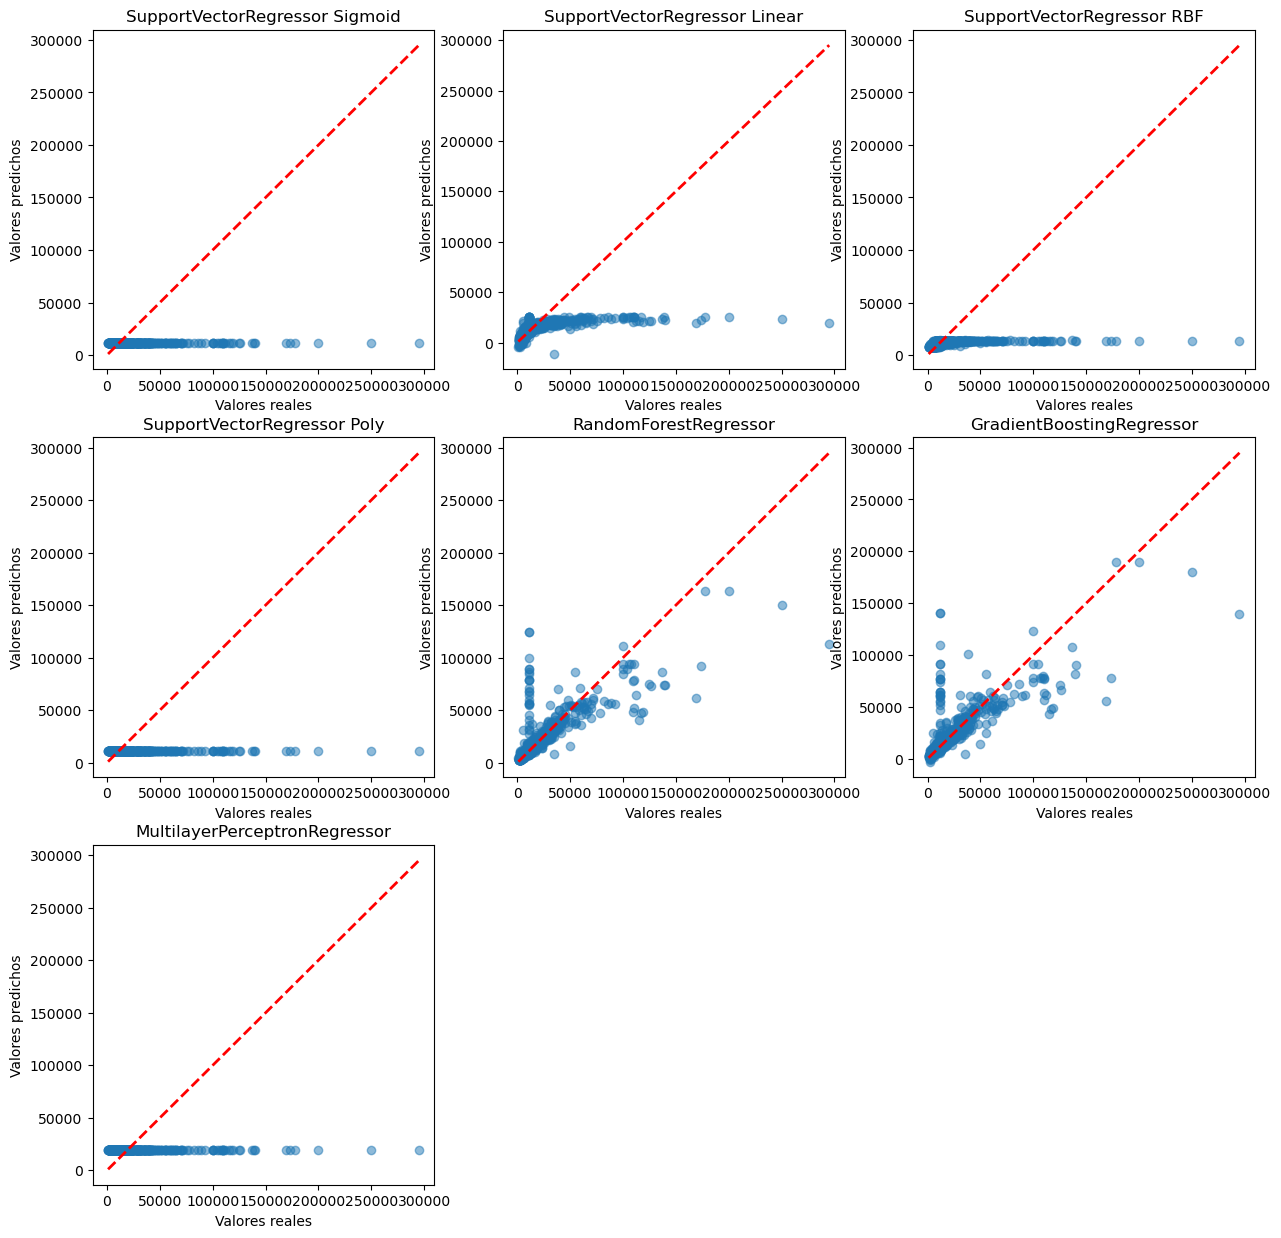

In [68]:
def plot_predicted_vs_actual(y_true, y_pred, model_name, ax):
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_xlabel('Valores reales')
    ax.set_ylabel('Valores predichos')
    ax.set_title(f'{model_name}')

# Crear la figura con subplots 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#axes = axes.flatten()  # Convertir el array 2D de ejes en 1D para facilitar la iteración


plot_predicted_vs_actual(y_test, svr_sigmoid_dataset['pred'], 'SupportVectorRegressor Sigmoid', axes[0,0])
plot_predicted_vs_actual(y_test, svr_linear_dataset['pred'], 'SupportVectorRegressor Linear', axes[0,1])
plot_predicted_vs_actual(y_test, svr_rbf_dataset['pred'], 'SupportVectorRegressor RBF', axes[0,2])
plot_predicted_vs_actual(y_test, svr_poly_dataset['pred'], 'SupportVectorRegressor Poly', axes[1,0])
plot_predicted_vs_actual(y_test, rfr_dataset['pred'], 'RandomForestRegressor', axes[1,1])
plot_predicted_vs_actual(y_test, gbr_dataset['pred'], 'GradientBoostingRegressor', axes[1,2])
plot_predicted_vs_actual(y_test, mlpr_dataset['pred'], 'MultilayerPerceptronRegressor', axes[2,0])

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

Este gráfico confirma lo que dijimos en el gráfico anterior. Sólo el RFR y el GBR se ajustan un poco a línea recta (no tanto como se esperaría). El resto ajusta muy mal.

#### Gráfico III: Q-Q Plot de Residuos

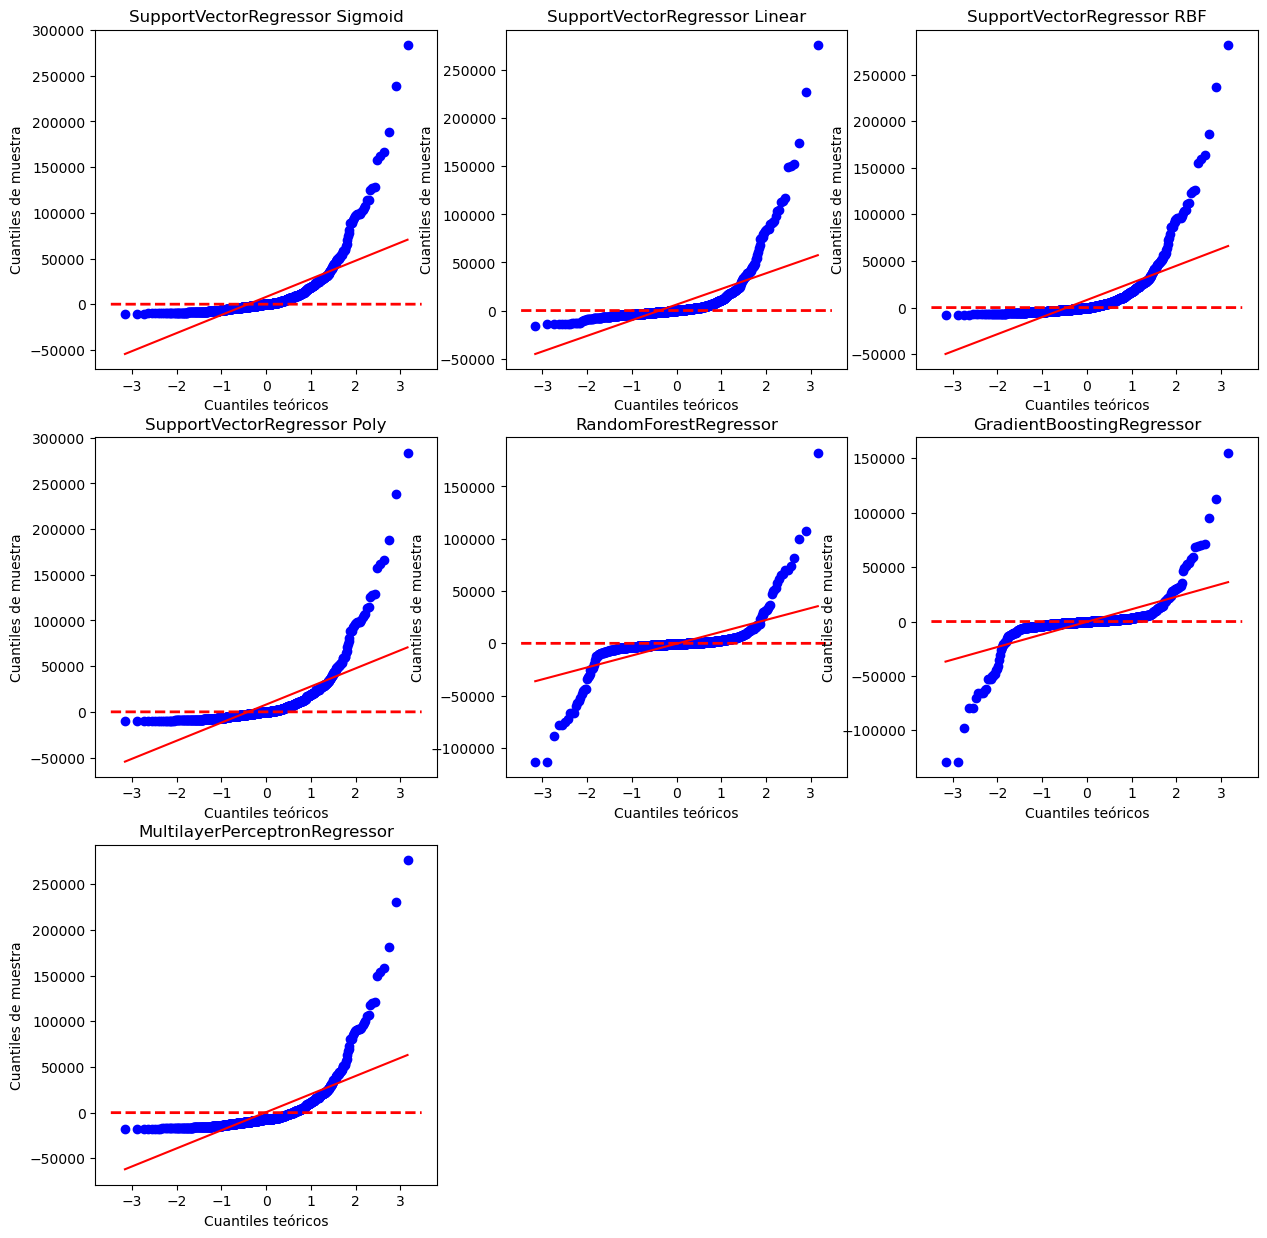

In [79]:
def create_qq_plot(residuals, model_name, ax):
    stats.probplot(residuals, dist="norm", plot=ax)
    
    # ax.set_title(f"Q-Q Plot de Residuos - {model_name}")
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Cuantiles teóricos")
    ax.set_ylabel("Cuantiles de muestra")
    
    # Añadir línea de referencia
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, linestyle='--', color='red', lw=2)

# Crear la figura con subplots 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Ejemplo de uso
# Asumiendo que tienes tus modelos y datos de prueba
residuals_svr_sigmoid = y_test - svr_sigmoid_dataset['pred']
residuals_svr_linear = y_test - svr_linear_dataset['pred']
residuals_svr_rbf = y_test - svr_rbf_dataset['pred']
residuals_poly = y_test - svr_poly_dataset['pred']
residuals_rfr = y_test - rfr_dataset['pred']
residuals_gbr = y_test - gbr_dataset['pred']
residuals_mlpr = y_test - mlpr_dataset['pred']

create_qq_plot(residuals_svr_sigmoid, 'SupportVectorRegressor Sigmoid', axes[0,0])
create_qq_plot(residuals_svr_linear, 'SupportVectorRegressor Linear', axes[0,1])
create_qq_plot(residuals_svr_rbf, 'SupportVectorRegressor RBF', axes[0,2])
create_qq_plot(residuals_poly, 'SupportVectorRegressor Poly', axes[1,0])
create_qq_plot(residuals_rfr, 'RandomForestRegressor', axes[1,1])
create_qq_plot(residuals_gbr, 'GradientBoostingRegressor', axes[1,2])
create_qq_plot(residuals_mlpr, 'MultilayerPerceptronRegressor', axes[2,0])

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

Este gráfico es otra opción distinta de ver lo que representa el gráfico II.